In [1]:
from dotenv import load_dotenv
import os

load_dotenv()

# Get environment variables as strings
llm_api_key = os.getenv('GROQ_API_KEY')
langchain_api_key = os.getenv('LANGCHAIN_API_KEY')
LANGCHAIN_TRACING_V2="true"
LANGCHAIN_ENDPOINT="https://api.smith.langchain.com"
LANGCHAIN_PROJECT="pr-downright-hacienda-56"

In [2]:
# Import necessary libraries
from typing import TypedDict, List, Annotated
from langchain_core.documents import Document
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages 
from langchain_core.prompts import PromptTemplate
from langchain_community.document_loaders import (
    PyPDFLoader,
    Docx2txtLoader, 
    UnstructuredPowerPointLoader, 
    CSVLoader, 
    UnstructuredExcelLoader
)
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_community.embeddings.sentence_transformer import SentenceTransformerEmbeddings
from langchain_chroma import Chroma
import chromadb
import pandas as pd
#from custom_agents_LG import agent_executor
from llm import get_llama_3dot3_70b_versatile,get_llama_3dot1_8b_instant,get_70b_8192
llm = get_70b_8192()

In [3]:
class State(TypedDict):
    # Messages have the type "list". The `add_messages` function in the annotation defines how the state should be updated. 
    #in this case append messages rather than overwrite
   # messages : Annotated[list, add_messages] # Everytime we get a new message, we update our state. 
   # question: str <---- removed as we have the messages list, might need to revisit
    context: List[Document]
    player_metrics: str
    answer: str
    player_name: str
graph_builder =  StateGraph(State)
graph_builder

In [4]:
# def extract_player_name(messages: list) -> str:
#     """Extract player name from the question using the LLM."""
#     name_extraction_prompt = """
#     Extract the player name(s) from the following question. 
#     If no specific player is mentioned, return None.
#     Only return the name(s) without any additional text.
    
#     Question: {question}
#     """
    
#     prompt = PromptTemplate.from_template(name_extraction_prompt)
#     # messages = prompt.invoke({"question": question})
#     # print(f"This is messages : \n {50*'-'} \n {messages} \n {50*'-'}")
#     formatted_messages = prompt.invoke({"messages": messages}) 
#     response = llm.invoke(formatted_messages).content.strip()
#     response = llm.invoke(messages).content.strip()
#     print(response)
#     return response if response.lower() != "none" else None
def extract_player_name(messages: list) -> str:
    name_extraction_prompt = """
    Extract player name(s) from these messages.
    Return None if no player mentioned.
    RETURN ONLY THE NAME AND NOTHING ELSE
    CRITICAL : Only return name(s) without additional text before or after the text.
    
    Messages: {messages}
    """
    prompt = PromptTemplate.from_template(name_extraction_prompt)
    formatted_messages = prompt.invoke({"messages": messages})
    response = llm.invoke(formatted_messages).content.strip()
    return response if response.lower() != "none" else None

In [5]:
state = State(
    messages=[],
    context=[],
    player_metrics="",
    answer="",
    player_name=""
)

In [6]:
def chat(question: str, state: State):
    state["messages"].append(question)  # Dictionary syntax
    initial = extract_player_name(state["messages"])
    return initial

In [7]:
graph_builder.add_node("chatbot", chat) # Node name will be chatbot, then func

In [8]:
# We must then connect it to the start and to the end node.
graph_builder.add_edge(START, "chatbot")
graph_builder.add_edge("chatbot", END)

In [9]:
graph=graph_builder.compile()

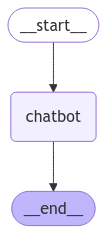

In [10]:
from IPython.display import Image, display
try :
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception: 
    print("Fail")

In [15]:
state = State(
    messages=[],
    context=[],
    player_metrics="",
    answer="",
    player_name=""
)

while True:
    user_input = input("User: ")
    if user_input.lower() in ["quit", "q"]:
        print("Bye")
        break
    for event in graph.stream({'messages' : ("user", user_input)}):
        print(event.values())
        for value in event.values():
            print(value['messages'])
        print("Assistant:", value['messages'].content)

InvalidUpdateError: Must write to at least one of ['context', 'player_metrics', 'answer', 'player_name']

# Test Zone

In [11]:
state = State(
    messages=[],
    context=[],
    player_metrics="",
    answer="",
    player_name=""
)


def chat_test(question: str, state: State):
    state["messages"].append(question)  # Dictionary syntax
    initial = extract_player_name(state["messages"])
    return initial
print(state)
x=chat_test(question ="What are Lee's injury risks based on his recent activity pattern?", state=state)
x # SO ESSENTIALLY WE HAVE OUR CHAT BOT, CHAT TEST, THAT IS INVOKING THE PRIOR
print(state)

{'messages': [], 'context': [], 'player_metrics': '', 'answer': '', 'player_name': ''}
{'messages': ["What are Lee's injury risks based on his recent activity pattern?"], 'context': [], 'player_metrics': '', 'answer': '', 'player_name': ''}


In [13]:
state

{'messages': ["What are Lee's injury risks based on his recent activity pattern?"],
 'context': [],
 'player_metrics': '',
 'answer': '',
 'player_name': ''}